# <div align='left'>Project - Skin Sight Vision</div>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime
import zipfile
import os

In [2]:
pip install --upgrade tensorflow==2.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 50.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Checking if GPU is available or not
if tf.config.list_physical_devices('GPU'):
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [5]:
# Getting GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ad28cfb7-06ed-c7ee-72b4-acdef17d771e)


### **Unzipping the Skin Cancer MNIST Dataset**

In [6]:
cd /content/drive/MyDrive/Project - Skin Cancer/

/content/drive/MyDrive/Project - Skin Cancer


In [7]:
def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [8]:
unzip_data("/content/drive/MyDrive/Project - Skin Cancer/Skin Cancer Data.zip")

### **Creating a new directory to store images into it**

In [9]:
import shutil
import os


# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):

	# Path
	path = os.path.join(parent_folder, folder_name)

	try:
		# mode of the folder
		mode = 0o777

		# Create folder
		os.mkdir(path, mode)
	except OSError as error:
		print(error)

# current folder path
current_folder = os.getcwd()

# list of folders to be merged
image_dir = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

content_list = {}
for index, val in enumerate(image_dir):
	path = os.path.join(current_folder, val)
	content_list[image_dir[index]] = os.listdir(path)

# folder in which all the content will be merged
merge_folder = "HAM10000_images"
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

	for contents in content_list[sub_dir]:

		path_to_content = sub_dir + "/" + contents
		dir_to_move = os.path.join(current_folder, path_to_content )
		shutil.move(dir_to_move, merge_folder_path)

### **Data Preprocessing**

In [10]:
# Reading the CSV data
skin_data = pd.read_csv(os.path.join(current_folder, 'HAM10000_metadata.csv'))
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [11]:
skin_data.tail()

lesion_id      image_id     dx dx_type   age     sex localization
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

In [12]:
skin_data.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [13]:
skin_data.shape

(10015, 7)

In [15]:
# Creating a dictionary of cell types
cell_type_dict = {
                    'akiec': 'Actinic keratoses',
                    'bcc': 'Basal cell carcinoma',
                    'bkl': 'Benign keratosis-like lesions ',
                    'df': 'Dermatofibroma',
                    'mel': 'Melanoma',
                    'nv': 'Melanocytic nevi',
                    'vasc': 'Vascular lesions'
                  }
skin_data['cell_type'] = skin_data['dx'].map(cell_type_dict.get)
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benign keratosis-like lesions               2  
4  Benign keratosis-like lesions               2

In [16]:
skin_data['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [17]:
# Get the class names
class_names = skin_data["cell_type"].unique()
class_names.tolist()

['Benign keratosis-like lesions ',
 'Melanocytic nevi',
 'Dermatofibroma',
 'Melanoma',
 'Vascular lesions',
 'Basal cell carcinoma',
 'Actinic keratoses']

#### **Data Visualization**

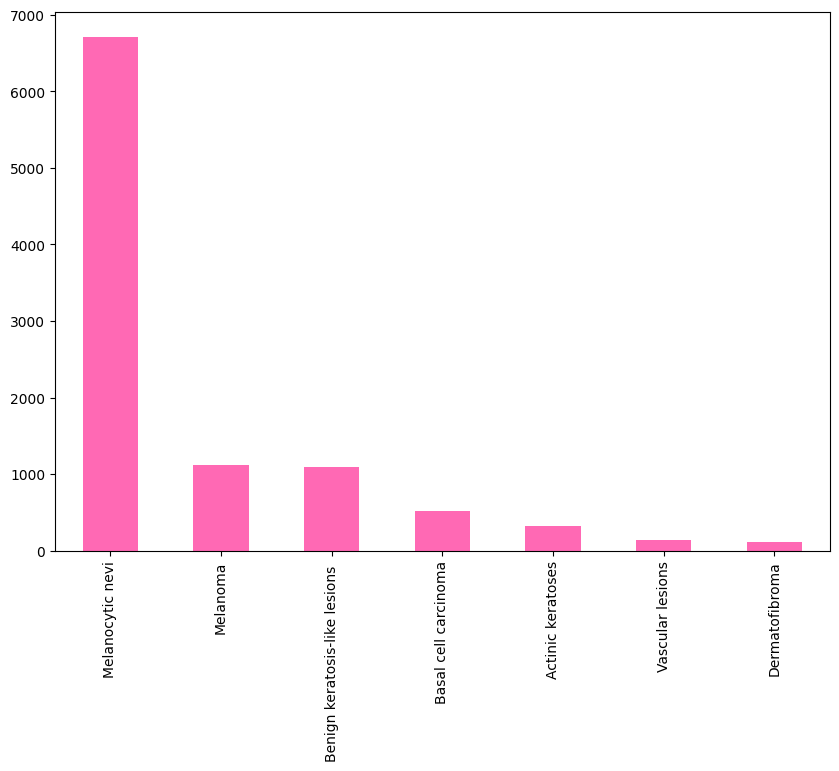

In [18]:
# Plot to visualize the distribution of different cell types
fig, ax = plt.subplots(figsize=(10,7))
skin_data['cell_type'].value_counts().plot(kind='bar', color='hotpink');

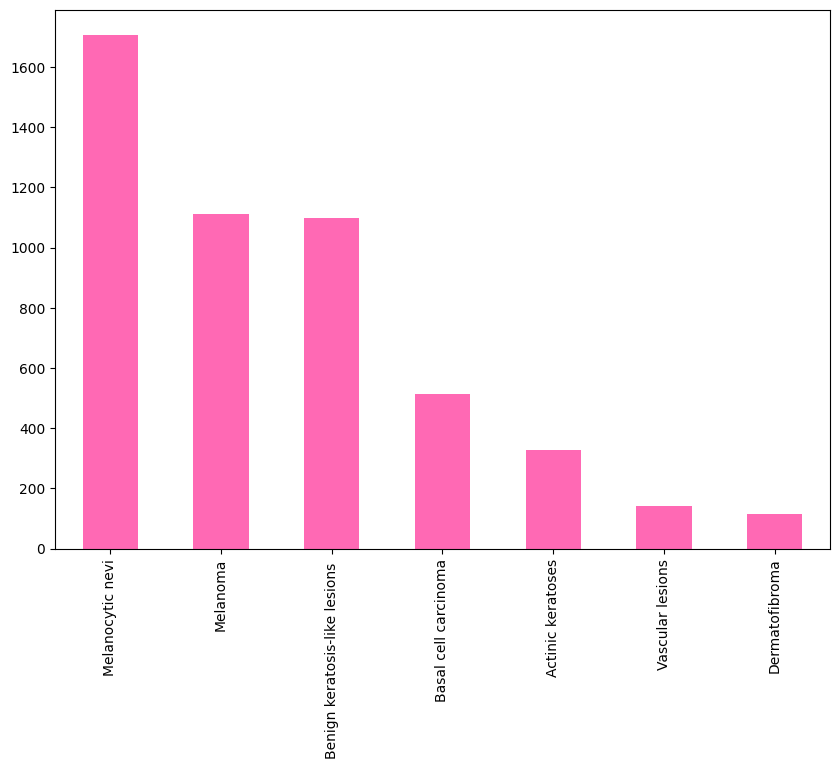

In [19]:
# As there is a little imbalance because of melanocytic nevi, so let's balance it
skin_data = skin_data.drop(skin_data[skin_data.cell_type_idx == 4].iloc[:5000].index)

fig, ax = plt.subplots(figsize= (10, 7))
skin_data['cell_type'].value_counts().plot(kind='bar', color='hotpink');

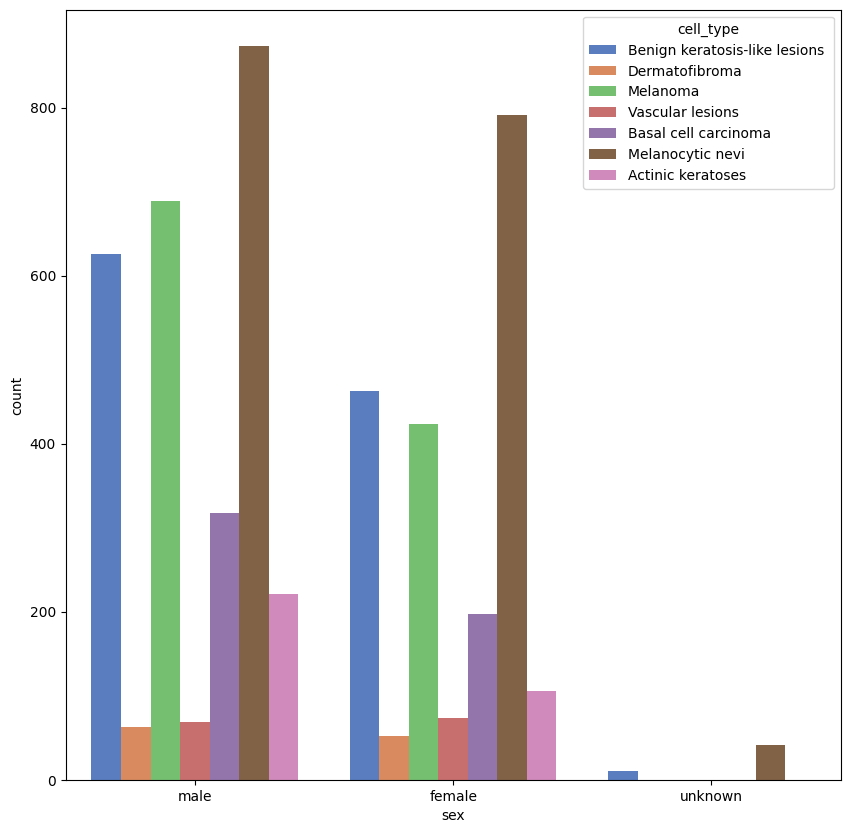

In [20]:
plt.figure(figsize=(10,10))
sns.countplot(x="sex", hue='cell_type', data=skin_data, palette='muted');

In [21]:
feature_1 = skin_data['localization'].unique()
feature_1

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

In [22]:
dx_type_labels = skin_data["dx_type"].unique()
dx_type_labels

array(['histo', 'confocal', 'consensus'], dtype=object)

In [23]:
def visualize_plots(df, feature_1, feature_2, labels):
    """
    This function plots the pie plot for the feature class of the dataset.
    """
    skin_df = df[feature_1].value_counts().to_frame()
    skin_dff = df[feature_2].value_counts().to_frame()
    pers = skin_dff.apply(lambda x: round((x / df.shape[0]) * 100, 2))
    skin_dff['Percentage'] = pers
    #add colors
    colors_for_pieplot = ['#99ff99','#ffcc99', '#FCF3CF']

    plt.figure(figsize=(35, 7))
    plt.subplot(121)
    bars = sns.barplot(x=skin_df.index, y=skin_df[feature_1], palette='pastel')
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_height().astype(int)
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8,
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label='Localization_Distribution', fontsize=10)

    plt.subplot(122)
    plt.pie(x=skin_dff['Percentage'].values,
            labels=labels,
            colors=colors_for_pieplot,
            explode=(0, 0.09, 0.09),
            autopct='%1.1f%%')
    plt.title(label='Dx_type_Proportion', fontsize=10)
    plt.show()

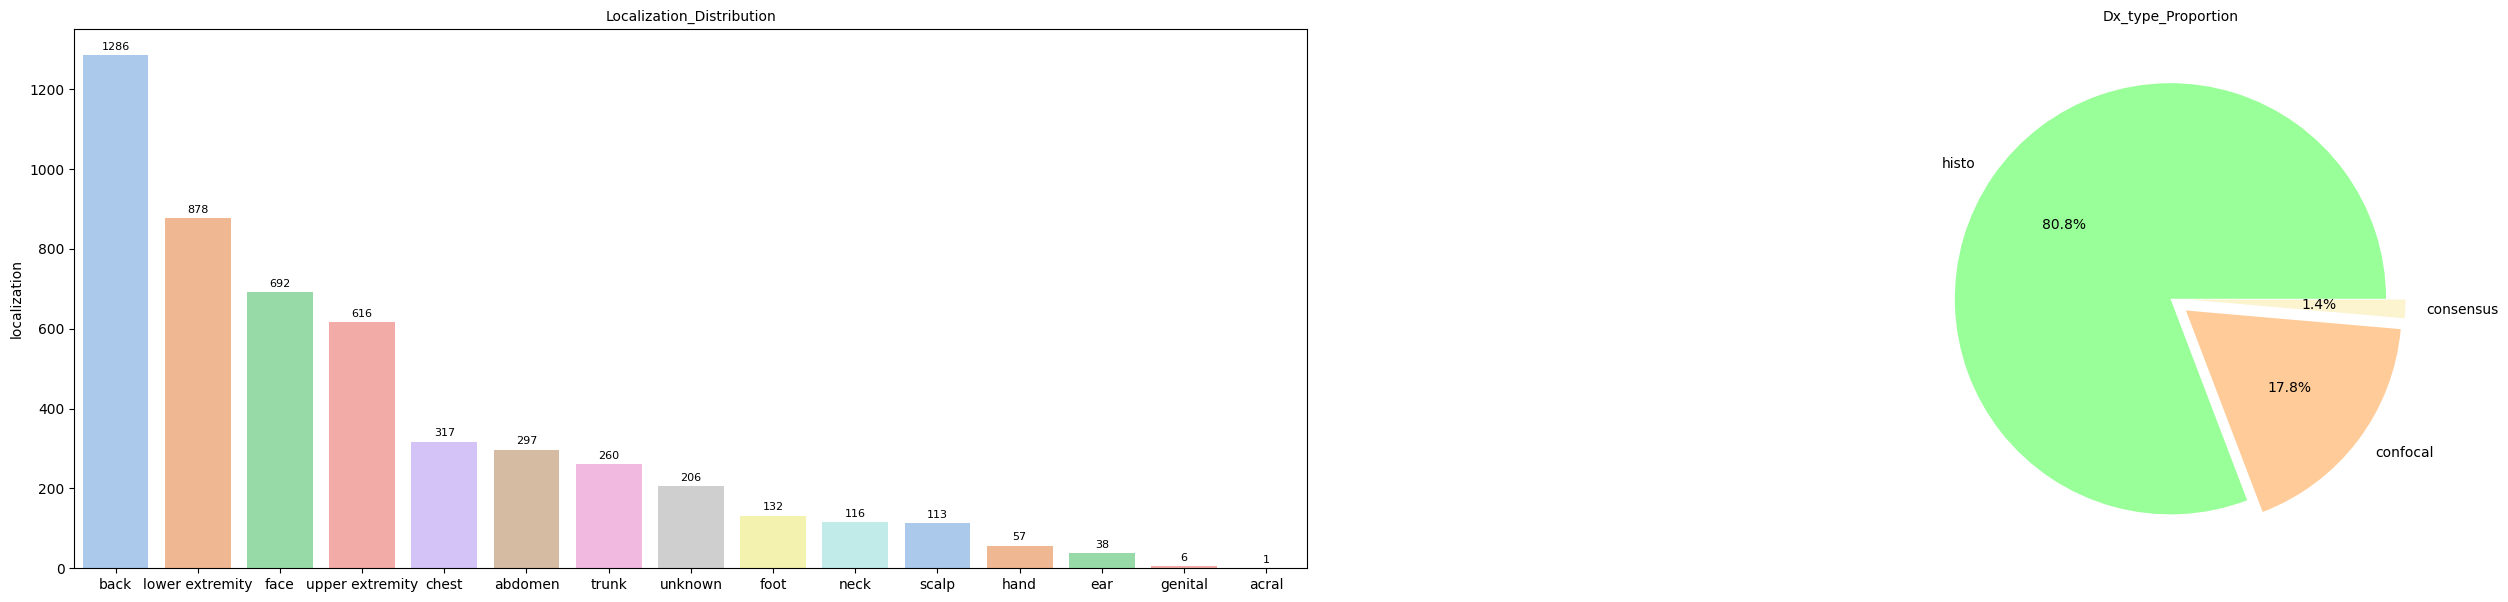

In [24]:
visualize_plots(df=skin_data, feature_1='localization', feature_2='dx_type', labels=dx_type_labels)

#### **Visualizing a Random Image from Skin Cancer Images Directory**

In [25]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.axis("off");

  print(f"Image shape: {img.shape}")             # show the shape of the image

  return img

['ISIC_0032001.jpg']
Image shape: (450, 600, 3)


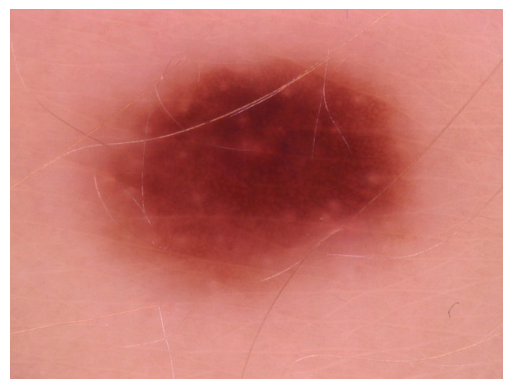

In [26]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images")

### **Creating train, test and valid directories by splitting images**

In [27]:
import os
import random
import shutil

data_path = "/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images"
main_path = "/content/drive/MyDrive/Project - Skin Cancer/"

# path to destination folders
train_folder = os.path.join(os.path.dirname(main_path), 'train')
val_folder = os.path.join(os.path.dirname(main_path), 'val')
test_folder = os.path.join(os.path.dirname(main_path), 'test')

# Define a list of image extensions
image_extensions = ['.jpg']

# Create a list of image filenames in 'data_path'
imgs_list = [filename for filename in os.listdir(data_path) if os.path.splitext(filename)[-1] in image_extensions]

# Sets the random seed
random.seed(42)

# Shuffle the list of image filenames
random.shuffle(imgs_list)

# determine the number of images for each set
train_size = int(len(imgs_list) * 0.8)
val_size = int(len(imgs_list) * 0.10)
test_size = int(len(imgs_list) * 0.10)

# Create destination folders if they don't exist
for folder_path in [train_folder, val_folder, test_folder]:
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Copy image files to destination folders
for i, f in enumerate(imgs_list):
    if i < train_size:
        dest_folder = train_folder
    elif i < train_size + val_size:
        dest_folder = val_folder
    else:
        dest_folder = test_folder
    shutil.copy(os.path.join(data_path, f), os.path.join(dest_folder, f))

### **Loading images data into train data, test data and valid data**

In [28]:
cd /content/drive/MyDrive/Project - Skin Cancer

/content/drive/MyDrive/Project - Skin Cancer


In [29]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = "/content/drive/MyDrive/Project - SkinCancer/train/"
valid_dir = "/content/drive/MyDrive/Project - SkinCancer/val/"
test_dir = "/content/drive/MyDrive/Project - SkinCancer/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory('.',
                                               classes=['train'],
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               shuffle=True,
                                               seed=42)

valid_data = valid_datagen.flow_from_directory('.',
                                               classes=['val'],
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               shuffle=True,
                                               seed=42)

test_data = test_datagen.flow_from_directory('.',
                                             classes=['test'],
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 8012 images belonging to 1 classes.
Found 1001 images belonging to 1 classes.
Found 1002 images belonging to 1 classes.


In [30]:
import numpy as np
labels = skin_data["cell_type"].to_numpy()
labels

array(['Benign keratosis-like lesions ', 'Benign keratosis-like lesions ',
       'Benign keratosis-like lesions ', ..., 'Actinic keratoses',
       'Actinic keratoses', 'Melanoma'], dtype=object)

In [31]:
# Find the unique label values
unique_labels = np.unique(labels)
unique_labels

array(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions ', 'Dermatofibroma',
       'Melanocytic nevi', 'Melanoma', 'Vascular lesions'], dtype=object)

In [32]:
# Turn every label into a boolean array
boolean_labels = [label == unique_labels for label in labels]
boolean_labels[:5]

[array([False, False,  True, False, False, False, False]),
 array([False, False,  True, False, False, False, False]),
 array([False, False,  True, False, False, False, False]),
 array([False, False,  True, False, False, False, False]),
 array([False, False,  True, False, False, False, False])]

In [33]:
# Example: Turning boolean array into integers
print(labels[0])            # Original label
print(np.where(unique_labels==labels[0]))        # index where label occurs
print(boolean_labels[0].argmax())                # index wher label occurs in boolean array
print(boolean_labels[0].astype(int))                # there will be a 1 where the sample label occurs

Benign keratosis-like lesions 
(array([2]),)
2
[0 0 1 0 0 0 0]


In [34]:
cd /content/drive/MyDrive/Project - Skin Cancer

/content/drive/MyDrive/Project - Skin Cancer


In [35]:
filenames = ["/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/"+fname+".jpg" for fname in skin_data["image_id"]]
filenames[:10]

['/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0027419.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0025030.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0026769.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0025661.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0031633.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0027850.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0029176.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0029068.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0025837.jpg',
 '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0025209.jpg']

In [36]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [37]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

### **Split the images into train and validation datasets**

In [38]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [39]:
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0031753.jpg',
  '/content/drive/MyDrive/Project - Skin Cancer/HAM10000_images/ISIC_0031061.jpg'],
 [array([False, False,  True, False, False, False, False]),
  array([False, False,  True, False, False, False, False])])

### **Converting images into Tensors**

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1(if necessary).

In [40]:
# Create a function to load and prepare images
IMG_SIZE = 224
def load_and_prep_image(filename, img_shape=IMG_SIZE, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filenames (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_jpeg(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[IMG_SIZE, IMG_SIZE])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [41]:
cd /content/drive/MyDrive/Project - Skin Cancer

/content/drive/MyDrive/Project - Skin Cancer


In [42]:
# Create a simple function to return a tuple(image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, process the image and returns a tuple of (image, label).
  """
  image = load_and_prep_image(image_path, scale=True)
  return image, label

### **Turning our data into batches**

Why turn our data into batches?

Let's say you are trying to process 10,000+ images in one go they all not might fit in the memory.

So that's why we do about 32 (this is the batch size) images at a time(you can manuallly adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`

In [43]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs
  Shuffles the data if it's training data but does not shuffle if its' validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test_data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X))    # only filepaths (no labels)
    data_batch = data.map(load_and_prep_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),         #filepaths
                                               tf.constant(y)))        #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [44]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [45]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 7), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 7), dtype=tf.bool, name=None)))

### **Visualizing Data Batches**

In [46]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(20,10))

  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    plt.tight_layout(pad=2.0)
    # Add the image label as the title
    plt.title(unique_labels[labels[i].argmax()], fontsize=7)
    # Turn the grid lines off
    plt.axis("off");

<ipython-input-46-748f9399cdec>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 5, i+1)


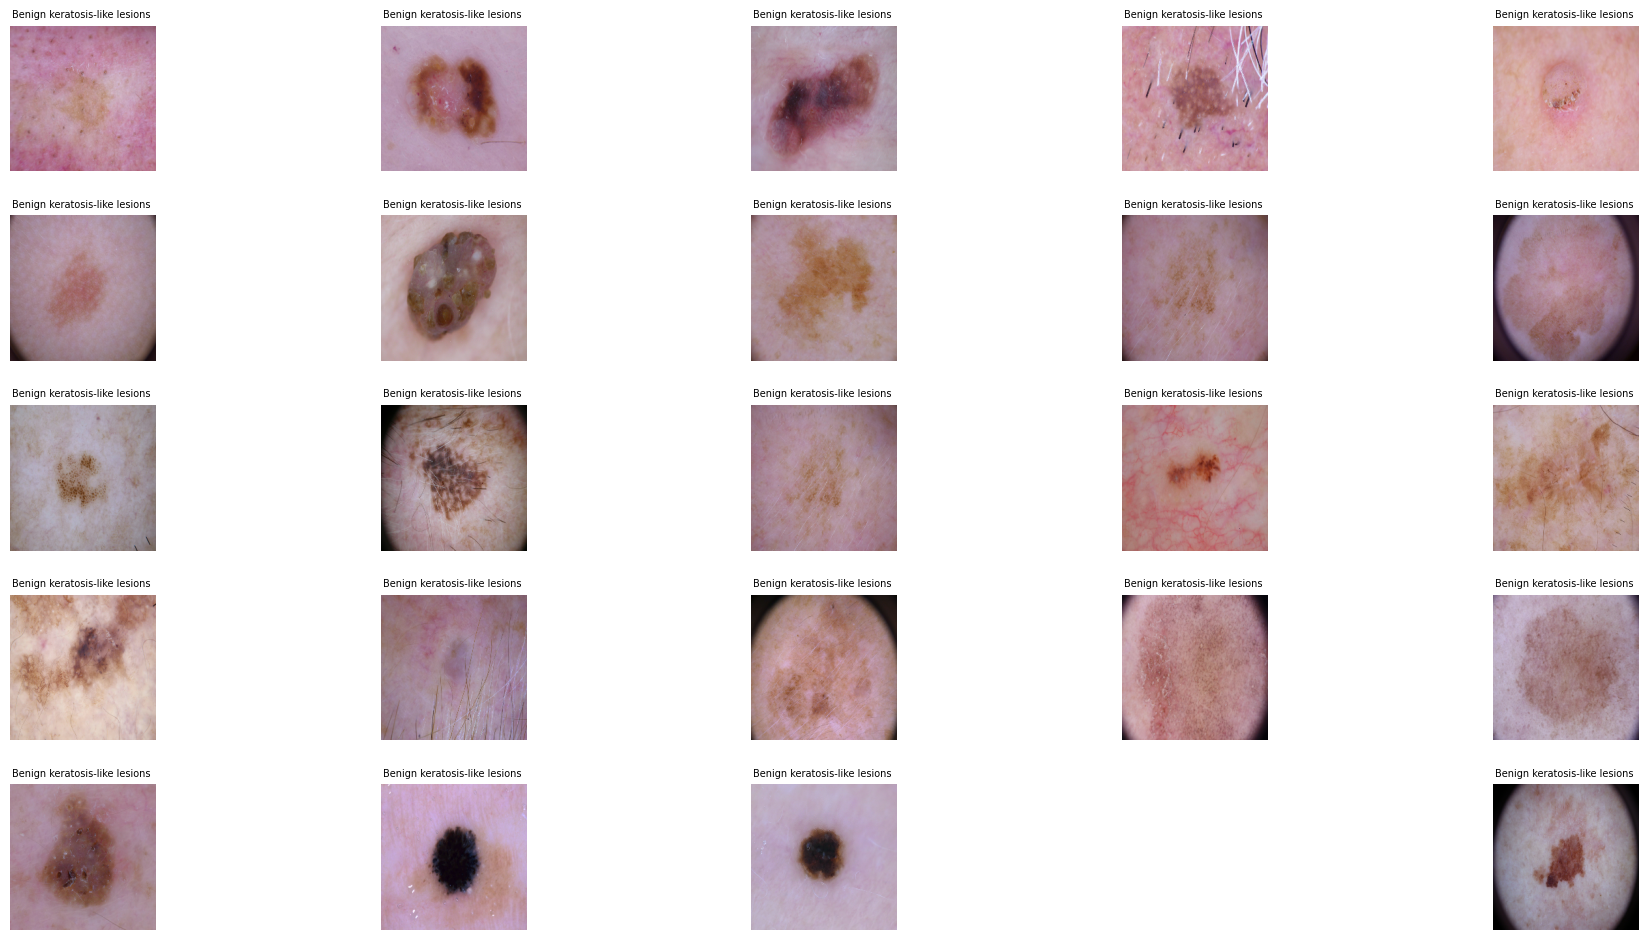

In [47]:
# Now lets' visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

<ipython-input-46-748f9399cdec>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 5, i+1)


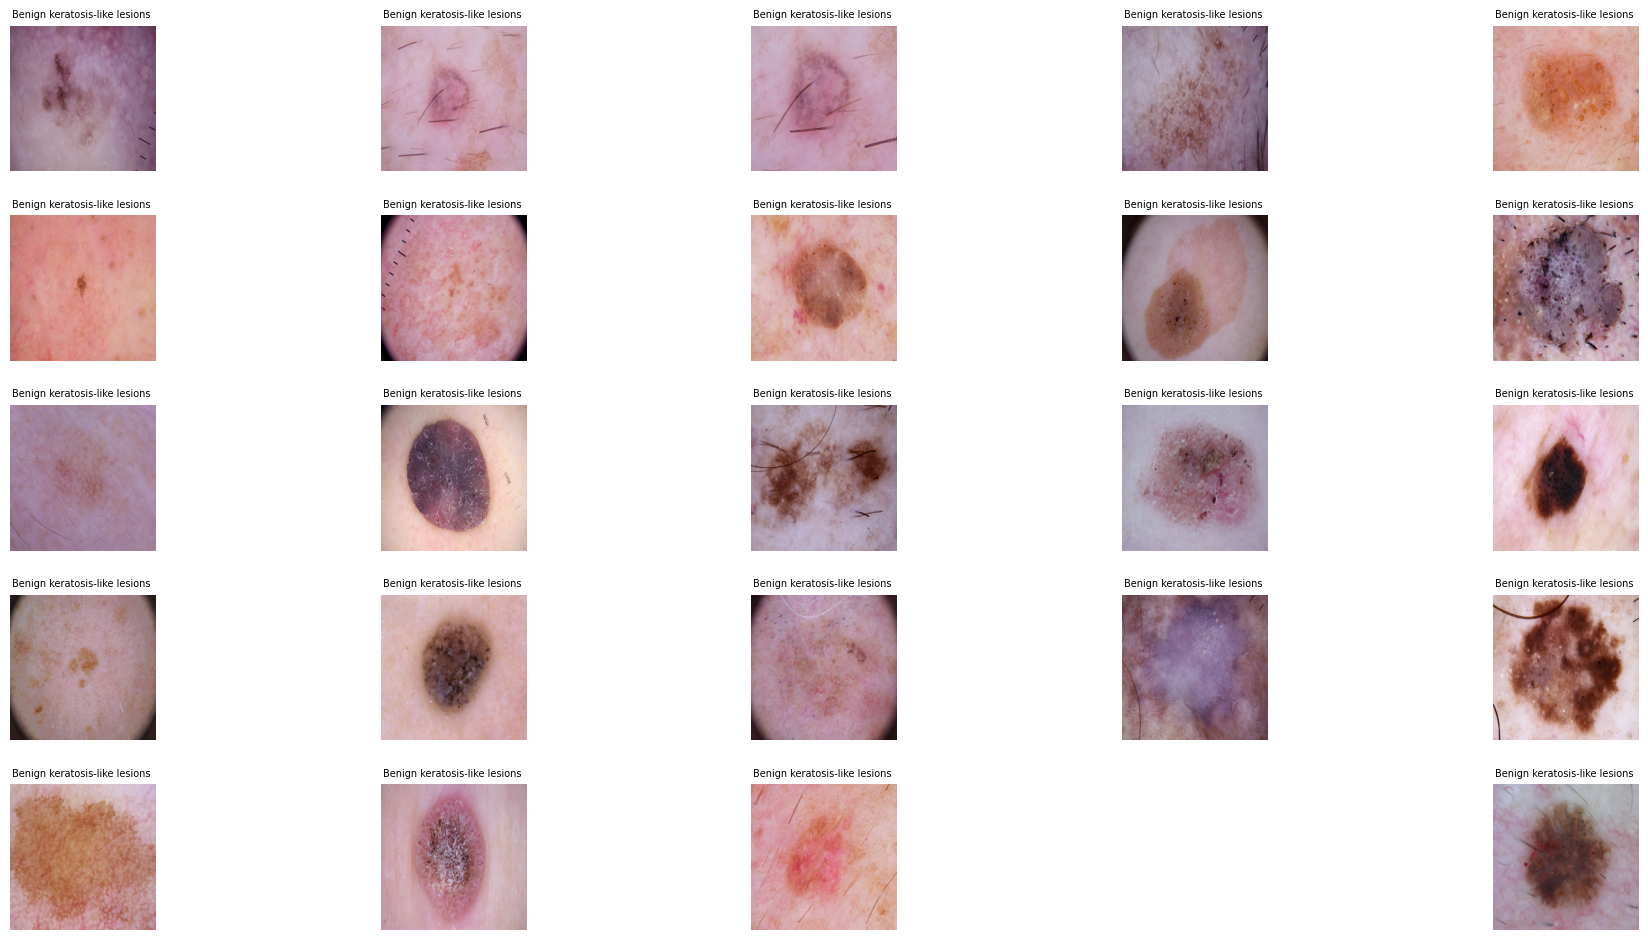

In [48]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### **Creating Model Checkpoint callbacks**

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* Model Checkpoint callback to save our model's progress

In [49]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [50]:
# Set EarlyStopping callback to stop training if model's val accuracy doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "/content/drive/MyDrive/Project - Skin Cancer/model_checkpoints/cp.ckpt"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       monitor="val_loss",
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       verbose=0)                   # don't print whether or not model is being saved

### **Adding data augmentation right into the model**

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top of your heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.

* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.


In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.)             # Keep for models like ResNet20V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

#### **Visualize our data augmentation layer (and see what happens to our data)**

In [52]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.axis("off")

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)
  plt.axis("off")

In [53]:
cd /content/drive/MyDrive/Project - Skin Cancer

/content/drive/MyDrive/Project - Skin Cancer


In [54]:
random_image = random.sample(os.listdir("train"), 1)
print(random_image)

target_folder = "/content/drive/MyDrive/Project - Skin Cancer/train"

# Read in the image and plot it using matplotlib
img = mpimg.imread(target_folder + "/" + random_image[0])

['ISIC_0027290.jpg']


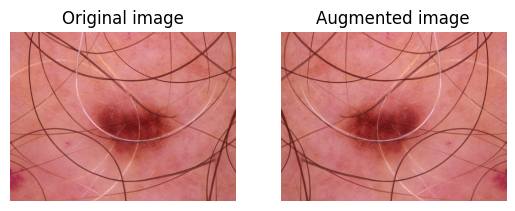

In [55]:
flipped = tf.image.flip_left_right(img)
visualize(img, flipped)

In [56]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(img, 0), tf.float32)

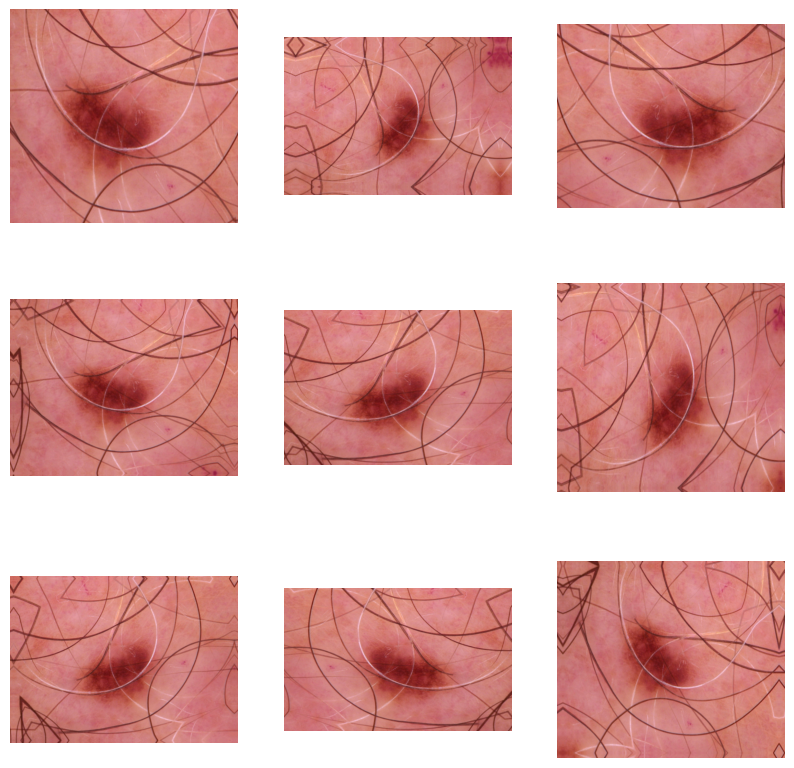

In [57]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis('off')

### **Tranfer Learning**
Transfer learning is a machine learning technique where a model trained on one task is adapted for use on a second, related task. It involves taking a pre-trained model and fine-tuning it for a new task, often requiring less data and computational resources than training a model from scratch.

Transfer Learning is been divided into two steps:-
* Feature Extraction
* Fine Tuning

#### **Implementing Feature Extraction**

In [58]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Setup input shape and base mode, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# Make a model using the inputs and outputs
model = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [59]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[

In [60]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#### **Model Training with only 10% of the full dataset**

In [61]:
# Fit the model
history_1 = model.fit(x=train_data,
                      epochs=10,
                      validation_data=val_data,
                      validation_freq=1,
                      batch_size=32,
                      callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Project - Skin Cancer",
                                                             experiment_name="Skin_Cancer_with_data_augmentation"),
                                 model_checkpoints,
                                 early_stopping])

Saving TensorBoard log files to: /content/drive/MyDrive/Project - Skin Cancer/Skin_Cancer_with_data_augmentation/20231028-093728
Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a58fa717b50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a58fa717b50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8662

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
25/25 [==============================] - 24s 450ms/step - loss: 0.4457 - accuracy: 0.8662 - val_loss: 3.9600e-04 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 8s 313ms/step - loss: 5.6002e-04 - accuracy: 1.0000 - val_loss: 1.3514e-04 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 8s 313ms/step - loss: 2.2260e-04 - accuracy: 1.0000 - val_loss: 1.2028e-04 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 8s 304ms/step - loss: 2.4735e-04 - accuracy: 1.0000 - val_loss: 1.1680e-04 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 8s 307ms/step - los

In [62]:
# Get the summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, None, None, 1280   2257984   
 tional)                     )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                             

#### **Unbatchifying data to train the model with full data**

In [63]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image,label) Tensors and returns separate arrays of images and labels.
  """

  images=[]
  labels=[]
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.4105861 , 0.26182064, 0.36312744],
         [0.42781863, 0.26680672, 0.36967003],
         [0.42942926, 0.27256653, 0.3764706 ],
         ...,
         [0.37420878, 0.2215161 , 0.3196396 ],
         [0.36565977, 0.21080956, 0.31271797],
         [0.37123597, 0.21769395, 0.3186246 ]],
 
        [[0.4160267 , 0.25819328, 0.36279762],
         [0.44163167, 0.27462047, 0.38060412],
         [0.42822754, 0.2811512 , 0.38030058],
         ...,
         [0.37634492, 0.21454826, 0.31963974],
         [0.37254903, 0.21677946, 0.3254222 ],
         [0.36958122, 0.21410155, 0.32090393]],
 
        [[0.41740197, 0.25745454, 0.35921213],
         [0.42921606, 0.28074542, 0.38048282],
         [0.42596444, 0.2861004 , 0.3803065 ],
         ...,
         [0.37543634, 0.2192399 , 0.32347628],
         [0.37770632, 0.21854718, 0.329199  ],
         [0.3654728 , 0.21776272, 0.3259663 ]],
 
        ...,
 
        [[0.4873986 , 0.36940476, 0.46007708],
         [0.4885361 , 0.37578064, 0.45924

In [64]:
# Create a data batch with the full training data set
full_train_data = create_data_batches(X, y)

Creating training data batches...


In [65]:
# Create a data batch with the full validation data set
full_validation_data = create_data_batches(X, y, valid_data=True)

Creating validation data batches...


In [66]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#### **Model Training with 100% of the data using Feature Extraction**

In [67]:
# Fit the model
history_feature_extraction = model.fit(x=full_train_data,
                                       epochs=100,
                                       steps_per_epoch=len(full_train_data),
                                       validation_data=full_validation_data,
                                       callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/Project - Skin Cancer",
                                                                              experiment_name="Skin_Cancer_with_Feature_Extraction"),
                                                  model_checkpoints,
                                                  early_stopping])

Saving TensorBoard log files to: /content/drive/MyDrive/Project - Skin Cancer/Skin_Cancer_with_Feature_Extraction/20231028-093912
Epoch 1/100


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a58f00e5510>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a58f00e5510>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - ETA: 0s - loss: 2.2170 - accuracy: 0.3362

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - 84s 515ms/step - loss: 2.2170 - accuracy: 0.3362 - val_loss: 1.2605 - val_accuracy: 0.5091
Epoch 2/100
157/157 [==============================] - 75s 481ms/step - loss: 1.4241 - accuracy: 0.4481 - val_loss: 1.1327 - val_accuracy: 0.5553
Epoch 3/100
157/157 [==============================] - 75s 475ms/step - loss: 1.2982 - accuracy: 0.5067 - val_loss: 1.0634 - val_accuracy: 0.6050
Epoch 4/100
157/157 [==============================] - 75s 480ms/step - loss: 1.2190 - accuracy: 0.5250 - val_loss: 1.0371 - val_accuracy: 0.6116
Epoch 5/100
157/157 [==============================] - 116s 739ms/step - loss: 1.1807

In [68]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 2s 154ms/step


array([[1.26936033e-01, 1.34302914e-01, 5.40011346e-01, ...,
        1.53292492e-01, 4.22159545e-02, 8.75428435e-04],
       [2.08059996e-02, 2.65582521e-02, 5.48811615e-01, ...,
        3.28397542e-01, 7.41966292e-02, 2.65957497e-05],
       [7.02941790e-02, 1.09622471e-01, 4.31152433e-01, ...,
        3.66110951e-01, 2.15413645e-02, 6.19975210e-04],
       ...,
       [5.27436614e-01, 2.25586668e-02, 2.72107035e-01, ...,
        3.67724746e-02, 1.39508665e-01, 2.41701200e-04],
       [1.09410085e-01, 8.00423622e-02, 2.88729548e-01, ...,
        4.01084125e-01, 1.07383773e-01, 5.02784853e-04],
       [9.22452435e-02, 9.99212563e-02, 3.01630735e-01, ...,
        2.60251641e-01, 2.37080351e-01, 2.33275956e-03]], dtype=float32)

In [69]:
model.save("/content/drive/MyDrive/Project - Skin Cancer/Skin_Cancer_with_Feature_Extraction/Skin_Cancer_FE.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  


#### **Evaluating Predictions**

In [70]:
# Turn predictions probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]


# Get a predicted label based on an array of predictions probabilities
pred_label = get_pred_label(predictions[72])
pred_label

'Actinic keratoses'

#### **Visualizing Predictions**

In [71]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

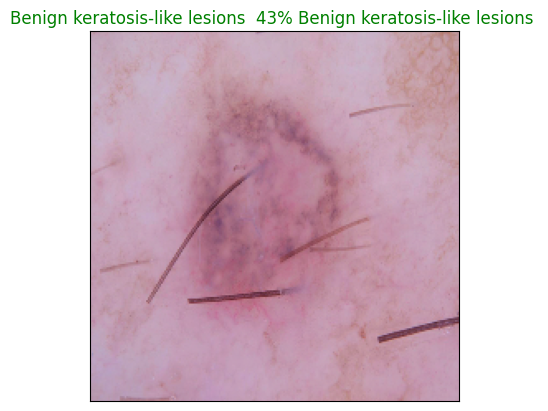

In [72]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=2)

In [73]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the  top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation="vertical")

  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

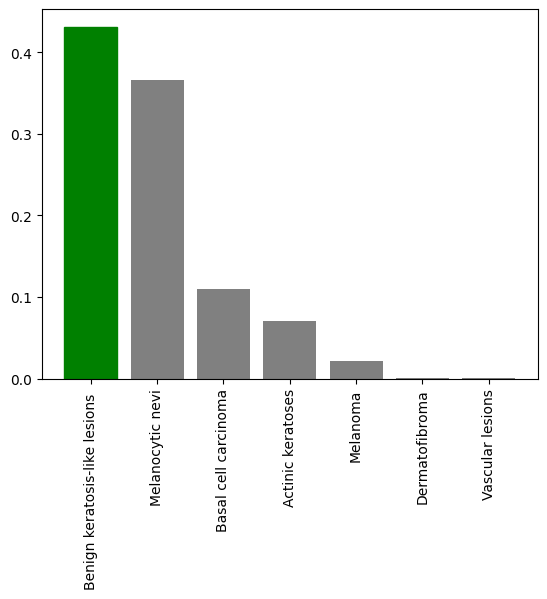

In [74]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=2)

### **Implementing Fine Tuning**

In [75]:
base_model.trainable = True

In [76]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-10]:
  layer.trainable = False

Number of layers in the base model:  154


In [77]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [78]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [79]:
model.layers

In [80]:
# Fit the model
history_fine_tuning = model.fit(x=full_train_data,
                                epochs=100,
                                steps_per_epoch=len(full_train_data),
                                initial_epoch=history_feature_extraction.epoch[-1],
                                validation_data=full_validation_data,
                                callbacks=early_stopping)

Epoch 31/100


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a58741a0220>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7a58741a0220>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - ETA: 0s - loss: 1.0902 - accuracy: 0.5665

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - 83s 476ms/step - loss: 1.0902 - accuracy: 0.5665 - val_loss: 0.8854 - val_accuracy: 0.6630
Epoch 32/100
157/157 [==============================] - 73s 469ms/step - loss: 0.9808 - accuracy: 0.6221 - val_loss: 0.7835 - val_accuracy: 0.7125
Epoch 33/100
157/157 [==============================] - 73s 469ms/step - loss: 0.9007 - accuracy: 0.6502 - val_loss: 0.7139 - val_accuracy: 0.7290
Epoch 34/100
157/157 [==============================] - 74s 470ms/step - loss: 0.8545 - accuracy: 0.6734 - val_loss: 0.6505 - val_accuracy: 0.7815
Epoch 35/100
157/157 [==============================] - 74s 471ms/step - loss: 0.7

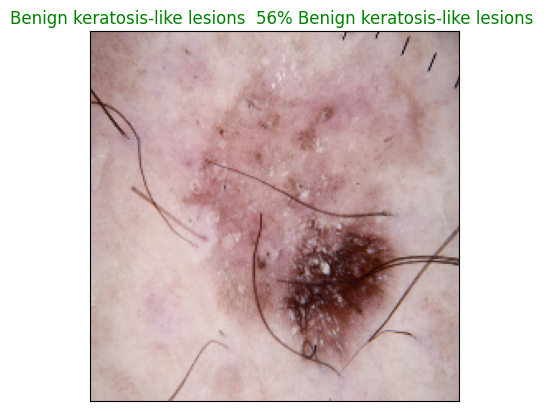

In [81]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=60)

In [82]:
model.save("/content/drive/MyDrive/Project - Skin Cancer/Skin Cancer with FineTuning/Skin_Cancer_FT.hdf5")